In [74]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [75]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 2

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [76]:
df_train = pd.read_csv('sample_train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))

Class distribution Train [ 117   46    8   24  103   98   49   14   12   56   10    2    3  185
  247   22 1383   22  171 1847   12  506  134  157  155   96    6   32
  114   35    3   27  160   77   75  146   45  810   19  743   21  141
  814   45   41]


sample_images/!_1191.jpg


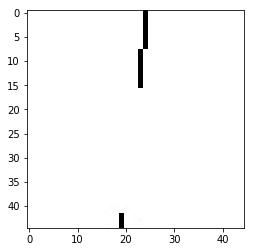

sample_images/!_148.jpg


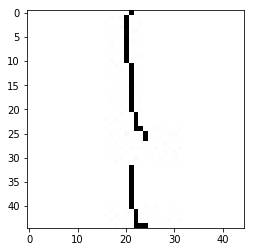

sample_images/(_1595.jpg


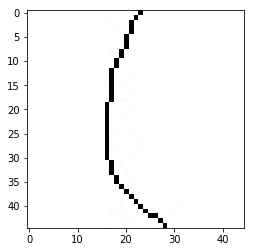

In [77]:
import glob
image_paths = sorted(glob.glob('sample_images/*.jpg'))
for i in (12, 25,500):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

In [80]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [81]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='sample_train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128, #### CHANGE IF YOU LIKE
                          shuffle=True,
                          num_workers=4)
print(train_loader)

valid_dataset = QuickdrawDataset(csv_path='sample_valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='sample_test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=4)

# Multilayer Perceptron Model

In [21]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2,num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
        
    def forward(self, x):
        
        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        ### ANYTHNG IN THE __init__ METHOD ABOVE
        out = self.linear_1(x)
        out=F.relu(out)
        out = self.linear_2(out)
        out=F.relu(out)

        
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU 
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.
model = MLP(num_features=NUM_FEATURES,
            num_hidden_1=50,
            num_hidden_2=50,
            num_classes=NUM_CLASSES)

model = model.to(DEVICE)


### For this homework, do not change the optimizer. However, you
### likely want to experiment with the learning rate!
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [18]:
#################################
### Training
#################################


################################################
# PLEASE DON'T CHANGE THE compute_epoch_loss
# and the compute accuracy functions
###############################################

def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

    
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model.forward(features)
            predicted_labels = torch.argmax(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    


start_time = time.time()
minibatch_cost = []
epoch_cost = []

#################################################################
### NO NEED TO CHANGE ANYTHING BELOW. HOWEVER, YOU CAN CHANGE
### THE NUMBER OF EPOCHS IF YOU LIKE
#################################################################

NUM_EPOCHS = 10 # Please feel free to change

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, NUM_FEATURES).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
        
    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    epoch_cost.append(cost)
    
    train_accuracy = compute_accuracy(model, train_loader)
    valid_accuracy = compute_accuracy(model, valid_loader)
    
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Train Accuracy: %.3f | Validation Accuracy: %.3f' % (train_accuracy, valid_accuracy))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 1, 5, 5], but got 2-dimensional input of size [128, 2025] instead

In [42]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

#  1) Implement a Convolutional Neural Network

In [42]:
##########################
### MODEL
##########################

class ConvNet1(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet1, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        #45*45*1=>45*45*16
        self.conv1 =  nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) #padding=[1(45-1)-45+5]/2=2
        #45*45*16=>15*15*16
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(15-1)-45+5]/2=1
        #15*15*16=>15*15*64
        self.conv2 =  nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2)  #padding=[1(15-1)-15+5]/2=2
        #15*15*64=>5*5*64
        self.maxpool2= nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(5-1)-16+5]/2=0.5
        #5*5*64=>5*5*256
        self.conv3 =  nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=1) #padding=[1(5-1)-5+3]/2=1
        #5*5*256=>1*1*256
        self.maxpool3= nn.MaxPool2d(kernel_size=5, stride=5) #padding=[5(1-1)-5+5]/2=0
        
        
        # ... <add the remaining convolutional layers
        # and fully connected layers ...
        
        self.linear1 = nn.Linear(256, 2048) 
        self.linear2 = nn.Linear(2048, 2048) 
        self.linear3 = nn.Linear(2048, NUM_CLASSES)  
        

    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        x = F.relu(x)
        x=self.maxpool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x=self.maxpool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x=self.maxpool3(x)
        
        
        x=x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x = F.relu(x)
        x=self.linear2(x)
        x = F.relu(x)
        
       
        
        
        
        
        # ... IMPLEMENT FORWARD PASS ...
        logits = self.linear3(x)# ...
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model1 = ConvNet1(NUM_CLASSES)


optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)  

In [8]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost
    

Epoch: 001/010 | Batch 0000/0070 | Cost: 28.3419
Epoch: 001/010 | Train: 78.094%
Time elapsed: 0.83 min
Epoch: 002/010 | Batch 0000/0070 | Cost: 0.8579
Epoch: 002/010 | Train: 89.211%
Time elapsed: 1.64 min
Epoch: 003/010 | Batch 0000/0070 | Cost: 0.4502
Epoch: 003/010 | Train: 93.456%
Time elapsed: 2.46 min
Epoch: 004/010 | Batch 0000/0070 | Cost: 0.2108
Epoch: 004/010 | Train: 95.687%
Time elapsed: 3.28 min
Epoch: 005/010 | Batch 0000/0070 | Cost: 0.1722
Epoch: 005/010 | Train: 96.434%
Time elapsed: 4.10 min
Epoch: 006/010 | Batch 0000/0070 | Cost: 0.2062
Epoch: 006/010 | Train: 97.113%
Time elapsed: 4.91 min
Epoch: 007/010 | Batch 0000/0070 | Cost: 0.0423
Epoch: 007/010 | Train: 98.075%
Time elapsed: 5.69 min
Epoch: 008/010 | Batch 0000/0070 | Cost: 0.0733
Epoch: 008/010 | Train: 98.517%
Time elapsed: 6.58 min
Epoch: 009/010 | Batch 0000/0070 | Cost: 0.0582
Epoch: 009/010 | Train: 98.845%
Time elapsed: 7.59 min
Epoch: 010/010 | Batch 0000/0070 | Cost: 0.0922
Epoch: 010/010 | Train: 

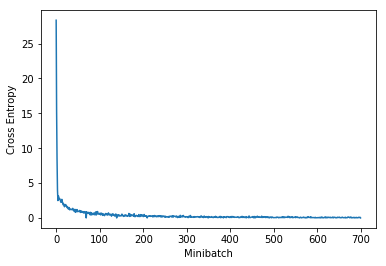

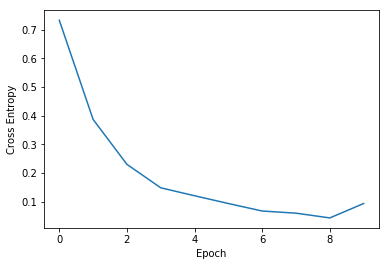

In [47]:
minibatch_cost, epoch_cost = train(model1, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [29]:
##########################
### MODEL
##########################

class ConvNet2(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet2, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        #45*45*1=>15*15*32
        self.conv1 =  nn.Conv2d(1, 32, kernel_size=5, stride=3,padding=1) #padding=[3(15-1)-45+5]/2=1
        
        #15*15*32=>3*3*128
        self.conv2 =  nn.Conv2d(32, 128, kernel_size=5, stride=5)  #padding=[5(3-1)-15+5]/2=0
        
        #3*3*128=>1*1*256
        self.conv3 =  nn.Conv2d(128, 256, kernel_size=5, stride=3) #padding=[3(1-1)-3+3]/2=0

        
        
        
        # ... <add the remaining convolutional layers
        # and fully connected layers ...
        
        self.linear1 = nn.Linear(256, 2048) 
        self.linear2 = nn.Linear(2048, 2048) 
        self.linear3 = nn.Linear(2048, NUM_CLASSES)  
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
       
        x = self.conv2(x)
        x = F.relu(x)
        
        
        x = self.conv3(x)
        x = F.relu(x)
        
        
        
        x=x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x = F.relu(x)
        
        x=self.linear2(x)
        x = F.relu(x)
        
       
        
        
        
        
        # ... IMPLEMENT FORWARD PASS ...
        logits = self.linear3(x)# ...
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model2 = ConvNet2(NUM_CLASSES)


optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)  

Epoch: 001/002 | Batch 0000/0070 | Cost: 3.8097
Epoch: 001/002 | Train: 16.959%
Time elapsed: 0.33 min
Epoch: 002/002 | Batch 0000/0070 | Cost: 2.7402
Epoch: 002/002 | Train: 67.123%
Time elapsed: 0.69 min
Total Training Time: 0.69 min
Test accuracy: 66.14%
Total Time: 0.70 min


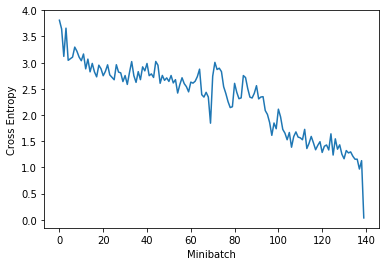

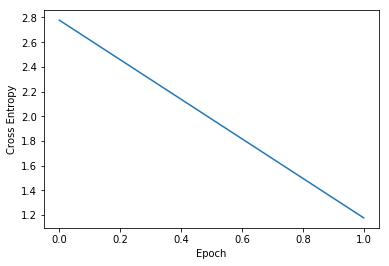

In [30]:
minibatch_cost, epoch_cost = train(model2, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# VGG

In [ ]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)

        return logits, probas

    
torch.manual_seed(random_seed)
model = VGG16(num_features=num_features,
              num_classes=num_classes)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)

        return logits, probas

    
torch.manual_seed(random_seed)
model = VGG16(num_features=num_features,
              num_classes=num_classes)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Resnet 

In [58]:
GRAYSCALE = True

In [59]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=5, stride=1, padding=2,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=3, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0],stride=4)
        self.layer2 = self._make_layer(block, 256, layers[1], stride=4)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.size())
        x = self.layer1(x)
        #print(x.size())
        x = self.layer2(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [60]:
torch.manual_seed(RANDOM_SEED)

##########################
### COST AND OPTIMIZER
##########################

model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [86]:
NUM_EPOCHS=5

In [87]:
BATCH_SIZE = 256

In [89]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='sample_train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128, #### CHANGE IF YOU LIKE
                          shuffle=True,
                          num_workers=4,drop_last=True)
print(train_loader)

valid_dataset = QuickdrawDataset(csv_path='sample_valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=4,drop_last=True)

test_dataset = QuickdrawDataset(csv_path='sample_test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=4,drop_last=True)

In [90]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

    
minibatch_cost, epoch_cost = [], []
all_train_acc, all_test_acc = [], []

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        print('Epoch: %03d/%03d | Train: %.3f%% | Test: %.3f%%' % (
              epoch+1, NUM_EPOCHS, train_acc, test_acc))
        
        all_train_acc.append(train_acc)
        all_test_acc.append(test_acc)
        cost = compute_epoch_loss(model, train_loader)
        epoch_cost.append(cost)


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 0000/0069 | Cost: 0.0566
Epoch: 001/005 | Train: 98.573% | Test: 95.724%
Time elapsed: 2.38 min
Epoch: 002/005 | Batch 0000/0069 | Cost: 0.0171
Epoch: 002/005 | Train: 98.053% | Test: 95.395%
Time elapsed: 4.92 min
Epoch: 003/005 | Batch 0000/0069 | Cost: 0.0581
Epoch: 003/005 | Train: 98.992% | Test: 96.711%
Time elapsed: 7.34 min
Epoch: 004/005 | Batch 0000/0069 | Cost: 0.0094
Epoch: 004/005 | Train: 99.060% | Test: 96.382%
Time elapsed: 9.72 min
Epoch: 005/005 | Batch 0000/0069 | Cost: 0.0794
Epoch: 005/005 | Train: 99.332% | Test: 97.081%
Time elapsed: 12.17 min
Total Training Time: 12.17 min
